<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/Ch9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_gpu==2.00-rc1

     |████████████████████████████████| 380.5MB 39kB/s 
     |████████████████████████████████| 4.3MB 59.0MB/s 
     |████████████████████████████████| 501kB 49.0MB/s 


In [3]:
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

## 09-2 순환 신경망을 만들고 텍스트를 분류합니다.
#### 텍스트 데이터 변환 방법을 알아보고 앞에서 유도한 경사 하강법 공식으로 순환 신경망 클래스를 구현해 보자.

> ### 훈련 세트와 검증 세트를 준비합니다.
#### IMDB 데이터 세트는 인터넷 영화 데이터 베이스에서 수집한 영화 리뷰 데이터이다. 순환 신경망으로 이 리뷰들이 긍정적인지 부정적인지 판별해보자. 훈련 세트 25,000개, 테스트 세트 25,000개로 구성되어 있으며 훈련 세트에서 5,000개의 세트를 분리하여 검증 세트로 사용한다.



In [0]:
import numpy as np
from tensorflow.keras.datasets import imdb

In [0]:
(x_train_all, y_train_all), (x_test, y_test)=imdb.load_data(skip_top=20, num_words=100)
# skip_top은 가장 많이 등장한 단어들 중 건너뛸 단어의 개수 지정
# num_words는 훈련에 사용할 단어의 개수 지정

In [12]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [13]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


#### 위는 영단어를 고유한 정수에 일대일 대응한 것으로, BoW(Bag of Word) 혹은 어휘 사전이라 부른다. 눈에 띄는 숫자인 2는 사전에 없는 단어를 의미한다. 가장 많이 등장하는 영단어 20개를 건너뛰고 100개 단어만 선택했기 때문에 사전에 없는 영단어가 많다. 추가로 0과 1은 각각 패딩과 글의 시작을 나타내는 데 사용한다. 이 숫자들을 제외하고 훈련 세트를 만든다.

In [14]:
len(x_train_all)

25000

In [15]:
for i in range(len(x_train_all)):
  x_train_all[i]=[w for w in x_train_all[i] if w>2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


#### 훈련 세트를 영단어로 바꿔보자. 어휘 사전은 get_word_index() 함수로 내려받을 수 있다. 이 함수는 영단어와 정수로 구성된 딕셔너리를 반환한다. 다음은 어휘 사전을 내려받은 다음 딕셔너리 키 값을 movie로 지정하여 값을 출력한 것이다.

In [16]:
word_to_index=imdb.get_word_index()
word_to_index['movie']

17

#### 훈련세트에 있는 정수는 3 이상부터 영단어를 의미하므로 3을 뺀 값을 어휘 사전의 인덱스로 사용해야 한다. 훈련 세트를 영단어로 변환하여 출력해 보자.

In [17]:
print(word_to_index['film']) # 훈련 데이터에서 22
print(word_to_index['just']) # 훈련 데이터에서 43

19
40


In [18]:
index_to_word={word_to_index[k]:k for k in word_to_index}

for w in x_train_all[0]:
  print(index_to_word[w-3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

#### 훈련 세트 입력 데이터는 넘파이 배열이 아닌 파이썬 리스트이다. 각 리뷰들의 길이가 달라 샘플의 길이가 다르기 때문이다. 두 샘플의 길이를 확인하여 보자.

In [19]:
print(len(x_train_all[0]), len(x_train_all[1])) # 샘플별 길이가 다름을 확인

59 32


#### 타깃 데이터도 확인해보자. 이진 분류이므로 타깃 데이터는 1과 0으로 영화 리뷰가 긍정(1)인지 부정(0)인지 나타낸다.

In [20]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


#### 검증 세트를 준비해 보자. 25,000개 훈련 세트 중 5,000개만 분리하여 검증 세이트로 사용하자. 넘파이 premutation() 함수를 이용하여 25,000개의 인덱스를 섞은 후 앞의 20,000개ㅐ는 훈련 세트로, 나머지는 검증 세트로 분리한다.

In [0]:
np.random.seed(42)
random_index=np.random.permutation(25000) # 섞은 것을 random.index로 지정

x_train=x_train_all[random_index[:20000]]
y_train=y_train_all[random_index[:20000]]
x_val=x_train_all[random_index[20000:]]
y_val=y_train_all[random_index[20000:]]

---
> ### 샘플의 길이 맞추기
#### 여기서는 일정 길이가 넘으면 샘플을 잘라버리고 모자라면 0으로 채워 샘플의 길이를 맞추도록 한다. 다음은 샘플의 길이를 7로 맞추기 위해 두 문장을 0으로 채우거나 자른 예이다.

#### 길이가 7 이하인 샘플의 왼쪽에 0을 추가했다는 것에 주목하자. 만약 오른쪽에 추가했다면 이후 샘플이 순환 신경망에 주입될 때 0이 마지막에 주입되므로 모델의 성능이 좋지 않을 것이다.

#### 텐서플로를 이용해 최대 길이를 100으로 설정하여 길이가 동일한 2개의 넘파이 배열 x_train_seq, x_val_seq를 만든다.

In [0]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

#### 훈련 세트의 크기를 확인해보자. 위에서 지정한 값으로 샘플의 길이가 변경되었다.

In [23]:
print(x_train_seq.shape, x_val_seq.shape) # 20,000개는 훈련 세트, 5,000개는 검증 세트

(20000, 100) (5000, 100)


In [24]:
print(x_train_seq[0]) # 샘플 길이 변경한 훈련 세트의 첫 번째 샘플 확인(왼쪽에 0으로 채워짐)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


---
> ### 샘플을 원-핫 인코딩하기
#### 훈련 데이터 준비를 위한 마지막 작업은 정수 데이터를 원-핫 인코딩하는 것이다.
#### 텐서플로의 to_categorical() 함수를 사용하면 원-핫 인코딩을 손쉽게 처리할 수 있다.

In [0]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

#### 변환시킨 후 크기를 확인하여 보자. 20,000개의 샘플이 100차원으로 원-핫 인코딩되었다.

In [26]:
print(x_train_onehot.shape)
print(x_train_onehot[0].shape)

(20000, 100, 100)
(100, 100)


#### 샘플을 100단어로 제한했지만 크기를 확인해 보면 760MB에 다다른다. 훈련에 사용할 단어의 개수가 늘어나면 컴퓨터의 메모리가 더 필요하다.

In [27]:
print(x_train_onehot.nbytes)

800000000


---
> ### 순환 신경망 클래스 구현하기
#### 이제 06장에서 구현했던 MiniBatchNetwork 클래스를 기반으로 순환 신경망을 파이썬으로 직접 구현해 보자.

#### *__*init__() 메서드는 은닉층의 개수 대신 셀 개수를 받는다. 그리고 셀에 필요한 가중치 w1h, w1x를 선언한다. 또 타임 스텝을 거슬러 그레디언트를 전파하려면 순환층의 활성화 출력을 모두 가지고 있어야 하므로 변수 h를 선언한다.

In [0]:
def __init__(self, n_cells=10, batch_size=32, lerning_rate=0.1):
  self.n_cells = n_cells       #셀 개수
  self.batch_size = batch_size # 배치 크기
  self.w1h = None              # 은닉 상태에 대한 가중치
  self.w1x = None              # 입력에 대한 가중치
  self.b1 = None               # 순환층의 절편
  self.w2 = None               # 출력층의 가중치
  self.b2 = None               # 출력층의 절편
  self.h = None                # 순환층의 활성화 출력
  self.losses = []             # 훈련 손실
  self.val_losses = []         # 검증 손실
  self.lr = lerning_rate       #학습률

#### 08장에서 글로럿 초기화 방식으로 가중치를 초기화하며 가중치 초기화의 중요성을 설명하였다. 순환 신경망에서는 직교 행렬 초기화(orthogonal initialization)를 사용한다. 이는 순환 셀에서 은닉 상태를 위한 가중치가 반복해서 곱해질 때 너무 커지거나 작아지지 않도록 만들어준다.

In [0]:
def init_weights(self, n_features, n_classes):
  orth_init = tf.initializers.Orthogonal() # 텐서플로가 제공하는 가중치 초기화 클래스 및 직교행렬 초기화 클래스
  glorot_init = tf.initializers.GlorotUniform()

  self.w1h = orth_init((self.n_cells, self.n_cells)).numpy() # 가중치 값이 초기화된 텐서를 넘파이 배열로 변환하여 가중치 변수에 저장 
  self.w1x = glorot_init((n_features, self.n_cells)).numpy()
  self.b1 = np.zeros(self.n_cells)
  self.w2 = glorot_init((self.n_cells, n_classes)).numpy()
  self.b2 = np.zeros(n_classes)

#### 정방향 계산을 forpass() 메서드에 구현한다.


In [0]:
def forpass(self, x):
  self.h = [np.zeros((x.shape[0], self.n_cells))] # 은닉 상태 초기화

#### 각 타임 스텝의 은닉 상태를 저장하기 위해 변수 h를 초기화 한다. 이때 은닉 상태 크기는 (샘플 개수, 셀 개수)이다. 역전파 과정 진행에서 이전 타임 스텝의 은닉 상태를 사용한다. 첫 번째 타임 스텝의 이전 은닉 상태는 없으므로 변수 h의 첫 번째 요소에 0으로 채워진 배열을 추가한다.

#### 그런 다음 넘파이의 swapaxes() 함수를 사용하여 입력 x의 배치 차원과 타임 스텝 차원을 바꾼다. 

In [0]:
seq=np.swapaxes(x,0,1) # 배치 차원과 타임 스텝 차원을 바꾼다.

#### 입력 x는 여러 개의 샘플이 담긴 미니 배치이다. 정방향 계산을 할 때는 한 샘플의 모든 타임 스텝을 처리하고 그 다음에 샘플을 처리하는 방식이 아니다. 미니 배치 안에 있는 모든 샘플의 첫 번째 타임 스텝을 한번에 처리하고 두 번째 타임 스텝을 한 번에 처리해야 한다. 이를 손쉽게 구현하기 위해 배치 차원과 타임 스텝 차원을 바꾼 것이다.

#### 마지막으로 각 샘플의 모든 타임 스텝에 대한 정방향 계산을 수행한다. 셀에서 계산된 은닉 상태는 변수 h에 순서대로 추가된다.

In [0]:
# 순환층의 선형식을 계산한다.
for x in seq:
  z1=np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
  h=np.tanh(z1)                    # 활성화 함수 적용
  self.h.append(h)                 # 역전파를 위한 은닉 상태 저장
  z2=np.dot(h, self.w2) + self.b2  # 출력층의 선형식 계산
return z2

#### 이제 역방향 계산을 backprop() 메서드로 구현해 보자. 여기서도 이 전과 같이 배치 차원과 타임 스텝 차원을 바꾸었다. err_to_cell 변수에 저장되는 값은 $Z_1$ 에 대하여 손실 함수를 미분한 도함수의 결괏값이다.

In [0]:
def backprop(self, x, err):
  m=len(x) # 샘플 개수

  # 출력층의 가중치와 절편에 대한 그레디언트 계산
  w2_grad = np.dot(self.h[-1].T, err) / m
  b2_grad = np.sum(err) / m
  # 배치 차원과 타임 스텝 차원을 바꾼다.
  seq = np.swapaxes(x, 0, 1)

  w1h_grad = w1x_grad = b1_grad = 0 # 초기 0지정
  # 셀 직전까지 그레디언트 계산 
  err_to_cell = np.dot(err, self.w2.T)*(1-self.h[-1]**2)
  # 모든 타임 스텝 거슬러 가며 그레디언트 전파
  # 열 번째 까지 진행, h의 마지막 항목은 err_to_cell 정의에 사용하였으므로 제외.
  # [A:B:C]코드는 indexA부터 indexB까지 C간격으로 만드는 코드
  for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
    w1h_grad += np.dot(h.T, err_to_cell)
    w1x_grad += np.dot(x.T, err_to_cell)
    b1_grad += np.sum(err_to_cell, axis=0)
    #이전 타임 스텝의 셀 직전까지 그레디언트 계산
    err_to_cell = np.dot(err_to_cell, self.w1h)*(1-h**2)

  w1h_grad /= m
  w1x_grad /= m
  b1_grad /= map
  
  return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

#### 딱 10개의 타임 스텝만 거슬러 진행한 이유는 무엇일까? 순환 신경망은 타임 스텝을 거슬러 올라가며 그레디언트를 전파할 때 동일한 가중치를 반복적으로 곱한다. 이로 인해 그레디언트가 너무 커지거나 작아지는 문제가 발생하기 쉽다. 이를 방지하기 위해 그레디언트를 전파하는 타임 스텝의 수를 제한해야 하는데, 이를 TBPTT(Truncated Backpropagation Through Time)라고 부른다. 그 다음 for문에서는 $W_{1h}$의 그레디언트(w1h_grad)를 구하기 위해 $Z_1$에 대한 손실함수의 미분값(err_to_cell)에 다음 식을 곱한다.

$$\frac{\partial Z_1}{\partial W_{1h}}=H_{p}+H_{pp}W_{1h}\odot(1-H_{p}^2)+H_{ppp}W_{1h}\odot(1-H_{p}^2)\odot W_{1h}\odot(1-H_{pp}^2)+\dots$$

#### 타임 스텝이 거슬러 가며 진행될 때마다 err_to_cell에 $W_{1h}\odot(1-H_{p}^2)$ 형태를 반복해서 곱함으로써 w1h_grad를 구하는 식을 $H$와 err_to_cell 만의 곱으로 단순화시켰다. 마찬가지로 $W_{1x}$의 그레디언트(w1x_grad)와 $b_1$의 그레디언트(b1_grad)도 누적된 err_to_cell 변수를 사용하여 손쉽게 계산 가능하다.

#### 순환 신경망, RecurrentNetwork 클래스의 전체 코드는 다음과 같다.

In [0]:
class RecurrentNetwork:

  def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
    self.n_cells = n_cells       #셀 개수
    self.batch_size = batch_size # 배치 크기
    self.w1h = None              # 은닉 상태에 대한 가중치
    self.w1x = None              # 입력에 대한 가중치
    self.b1 = None               # 순환층의 절편
    self.w2 = None               # 출력층의 가중치
    self.b2 = None               # 출력층의 절편
    self.h = None                # 순환층의 활성화 출력
    self.losses = []             # 훈련 손실
    self.val_losses = []         # 검증 손실
    self.lr = learning_rate       #학습률

  def forpass(self, x):
    self.h = [np.zeros((x.shape[0], self.n_cells))] # 은닉 상태 초기화
    seq = np.swapaxes(x, 0, 1) # 배치 차원과 타임 스텝 차원을 바꾼다.
    # 순환층의 선형식을 계산한다.
    for x in seq:
      z1=np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
      h=np.tanh(z1)                    # 활성화 함수 적용
      self.h.append(h)                 # 역전파를 위한 은닉 상태 저장
      z2=np.dot(h, self.w2) + self.b2  # 출력층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m=len(x) # 샘플 개수

    # 출력층의 가중치와 절편에 대한 그레디언트 계산
    w2_grad = np.dot(self.h[-1].T, err) / m
    b2_grad = np.sum(err) / m
    # 배치 차원과 타임 스텝 차원을 바꾼다.
    seq = np.swapaxes(x, 0, 1)

    w1h_grad = w1x_grad = b1_grad = 0 # 초기 0지정
    # 셀 직전까지 그레디언트 계산 
    err_to_cell = np.dot(err, self.w2.T)*(1-self.h[-1]**2)
    # 모든 타임 스텝 거슬러 가며 그레디언트 전파
    # 열 번째 까지 진행, h의 마지막 항목은 err_to_cell 정의에 사용하였으므로 제외.
    # [A:B:C]코드는 indexA부터 indexB까지 C간격으로 만드는 코드
    for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
      w1h_grad += np.dot(h.T, err_to_cell)
      w1x_grad += np.dot(x.T, err_to_cell)
      b1_grad += np.sum(err_to_cell, axis=0)
      #이전 타임 스텝의 셀 직전까지 그레디언트 계산
      err_to_cell = np.dot(err_to_cell, self.w1h)*(1-h**2)

    w1h_grad /= m
    w1x_grad /= m
    b1_grad /= m
  
    return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1+np.exp(-z))  # 시그모이드 계산
    return a

  def init_weights(self, n_features, n_classes):
    orth_init = tf.initializers.Orthogonal() # 텐서플로가 제공하는 가중치 초기화 클래스 및 직교행렬 초기화 클래스
    glorot_init = tf.initializers.GlorotUniform()

    self.w1h = orth_init((self.n_cells, self.n_cells)).numpy() # 가중치 값이 초기화된 텐서를 넘파이 배열로 변환하여 가중치 변수에 저장 
    self.w1x = glorot_init((n_features, self.n_cells)).numpy()
    self.b1 = np.zeros(self.n_cells)
    self.w2 = glorot_init((self.n_cells, n_classes)).numpy()
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): # x는 훈련 데이터, y는 타깃 데이터
    y=y.reshape(-1,1)
    y_val=y_val.reshape(-1,1)
    np.random.seed(42)
    self.init_weights(x.shape[2], y.shape[1])  # 은닉층과 출력층의 가중치 초기화
    # epochs만큼 반복한다.
    for i in range(epochs):
      print("에포크", i, end=' ')
      # 제너레이터 함수에서 반환한 미니배치 순환한다.
      batch_losses=[]
      for x_batch, y_batch in self.gen_batch(x,y):
        print('.', end='')
        a=self.training(x_batch, y_batch) ## 07장 training 메서드에서 x_val, y_val을 지운다.
        # 안전한 로그 계산을 위해 클리핑한다.
        a=np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가한다.
        loss=np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
        batch_losses.append(loss)
      print()
      self.losses.append(np.mean(batch_losses))
      # 검증 세트에 대한 손실 계산
      self.update_val_loss(x_val, y_val)

  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size # 미니 배치 횟수
    if length % self.batch_size:
      bins += 1                      # 나누어 떨어지지 않을 때 배치 횟수 1추가
    indexes=np.random.permutation(np.arange(len(x))) # 인덱스 섞기
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size*i
      end = self.batch_size*(i+1)               
      yield x[start:end], y[start:end]  # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y): ## 07장 training 메서드에서 x_val, y_val을 지운다.
    m=len(x)          # 샘플 개수 저장
    z=self.forpass(x) # 정방향 계산 수행
    a=self.sigmoid(z) # 활성화 함수 저장
    err=-(y-a)        # 오차 계산
    # 오차를 역전파하여 그레디언트 계산
    w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    # 셀의 가중치와 절편 업데이트
    self.w1h -= self.lr*w1h_grad
    self.w1x -= self.lr*w1x_grad
    self.b1 -= self.lr*b1_grad
    # 출력층의 가중치와 절편 업데이트
    self.w2 -= self.lr*w2_grad
    self.b2 -= self.lr*b2_grad
    return a

  def predict(self, x):
    z=self.forpass(x)  # 정방향 계산 수행
    return z>0         # 스텝 함수 적용

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 True의 비율 반환
    return np.mean(self.predict(x)==y.reshape(-1,1))

  def update_val_loss(self, x_val, y_val):
    z=self.forpass(x_val)         # 정방향 계산 수행
    a=self.sigmoid(z)             # 활성화 함수 적용
    a=np.clip(a, 1e-10, 1-1e-10)  # 출력값 클리핑
    val_loss=np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append(val_loss)

---
> ### 순환 신경망 모델 훈련시키기
#### 준비한 IDMB 데이터 세트에 RecurrentNetwork 클래스를 적용해 보자.

#### 셀 개수는 32개, 배치 크기는 32개, 학습률은 0.01, 에포크 횟수는 20을 사용한다. 이런 값을 포함해 TBPTT를 위한 타임 스텝 횟수는 모두 하이퍼 파라미터이다. 데이터 세트에 따라 반복적인 실험을 통해 적절한 값을 찾아야 한다.

In [35]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

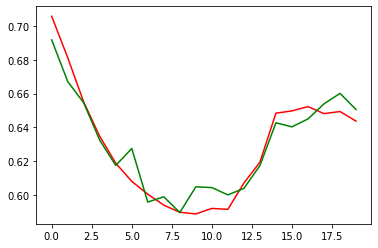

In [39]:
import matplotlib.pyplot as plt

plt.plot(rn.losses, color='red', label="losses")
plt.plot(rn.val_losses, color='green', label="val_losses")
plt.show()

In [40]:
rn.score(x_val_onehot, y_val) # 검증 세트 정확도 평가

0.6054

In [41]:
# epochs=10으로 재설정

rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=10, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

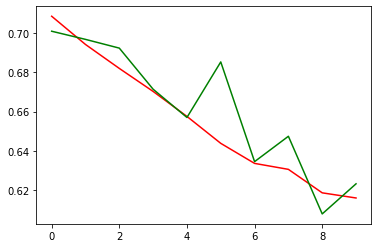

In [42]:
import matplotlib.pyplot as plt

plt.plot(rn.losses, color='red', label="losses")
plt.plot(rn.val_losses, color='green', label="val_losses")
plt.show()

In [43]:
rn.score(x_val_onehot, y_val)

0.6472

#### 영화 리뷰가 긍정인지 부정인지를 무작위로 예측하는 확률(50%)보다는 좋은 성능이 나왔다. 하지만 실전에 투입하기에는 조금 아쉬운 성능이다. 다음 절에서 텐서플로를 사용해 여러 고급 기술을 사용한 순환 신경망을 만들어 볼 것이다.